# Install Libraries

In [ ]:
!pip install simpletransformers
!pip install --upgrade huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 2

# Import dataset

In [ ]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en')

import pickle
with open("dict_dataset.pkl", "rb") as myFile:
    dict_dataset = pickle.load(myFile)

train_dataset = dict_dataset['train']
val_dataset = dict_dataset['validation']
test_dataset = dict_dataset['test']

Mounted at /content/drive


# Access transformer model and tokenizer

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model.eval()
start_token = tokenizer(tokenizer.bos_token, return_tensors='pt').data['input_ids'][0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def top_k_logits(logits, k):
    """
    Filters logits to only the top k choices
    from https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_gpt2.py
    """
    if k == 0:
        return logits
    values, _ = torch.topk(logits, k)
    min_values = values[:, -1]
    return torch.where(logits < min_values,
                       torch.ones_like(logits, dtype=logits.dtype) * -1e10,
                       logits)

def postprocess(token):
    with_space = False
    with_break = False
    if token.startswith('Ġ'):
        with_space = True
        token = token[1:]
        # print(token)
    elif token.startswith('â'):
        token = ' '
    elif token.startswith('Ċ'):
        token = ' '
        with_break = True

    token = '-' if token.startswith('â') else token
    token = '“' if token.startswith('ľ') else token
    token = '”' if token.startswith('Ŀ') else token
    token = "'" if token.startswith('Ļ') else token

    return token

In [ ]:
import numpy as np
def check_probabilities(in_text, topk = 100):
    # Process input
    token_ids = tokenizer(in_text, return_tensors='pt').data['input_ids'][0]
    token_ids = torch.concat([start_token, token_ids])

    # Forward through the model
    output = model(token_ids.to(device))
    all_logits = output.logits[:-1].detach().squeeze()
    # construct target and pred
    all_probs = torch.softmax(all_logits, dim=1)

    y = token_ids[1:]
    # Sort the predictions for each timestep
    sorted_preds = torch.argsort(all_probs, dim=1, descending=True).cpu()
    # [(pos, prob), ...]
    real_topk_pos = list(
        [int(np.where(sorted_preds[i] == y[i].item())[0][0])
          for i in range(y.shape[0])])
    real_topk_probs = all_probs[np.arange(
        0, y.shape[0], 1), y].data.cpu().numpy().tolist()
    real_topk_probs = list(map(lambda x: round(x, 5), real_topk_probs))

    real_topk = list(zip(real_topk_pos, real_topk_probs))
    # [str, str, ...]
    bpe_strings = tokenizer.convert_ids_to_tokens(token_ids[:])

    bpe_strings = [postprocess(s) for s in bpe_strings]

    topk_prob_values, topk_prob_inds = torch.topk(all_probs, k=topk, dim=1)

    pred_topk = [list(zip(tokenizer.convert_ids_to_tokens(topk_prob_inds[i]),
                          topk_prob_values[i].data.cpu().numpy().tolist()
                          )) for i in range(y.shape[0])]
    pred_topk = [[(postprocess(t[0]), t[1]) for t in pred] for pred in pred_topk]


    payload = {'bpe_strings': bpe_strings,
                'real_topk': real_topk,
                'pred_topk': pred_topk}
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return payload

In [ ]:
def color_text(text, payload):
    colored_text = ''
    l = len(text)
    count = {}
    count['green'] = 0
    count['yellow'] = 0
    count['purple'] = 0
    count['red'] = 0
    pred = 0 # default generated

    for word in range(len(text)):
        if 0 <= payload['real_topk'][word][0] < 10:
            colored_text += '\033[48;2;204;255;204m' + text[word] + '\033[0m' + ' '  # Pastel green
            count['green'] += 1
        elif 10 <= payload['real_topk'][word][0] < 100:
            colored_text += '\033[48;2;255;255;153m' + text[word] + '\033[0m' + ' '  # Pastel yellow
            count['yellow'] += 1
        elif 100<= payload['real_topk'][word][0] < 1000:
            colored_text += '\033[48;2;204;153;255m' + text[word] + '\033[0m' + ' '  # Pastel purple
            count['purple'] += 1
        elif payload['real_topk'][word][0] > 1000:
            colored_text += '\033[48;2;255;153;153m' + text[word] + '\033[0m' + ' '  # Pastel red
            count['red'] += 1

    #print('Count: ', count['green'], 'Text length: ', l)
    if count['green'] > l*2/3:
      return colored_text, pred
    else:
      pred = 1 # human
      return colored_text, pred

In [ ]:
def classify_text(in_text):
  # Tokenize input text
  tokens = tokenizer.tokenize(in_text)

  # Filter out special tokens and convert tokens to string
  text = [postprocess(token) for token in tokens if not tokenizer.special_tokens_map.get(token)]

  # Obtain probabilities
  payload = check_probabilities(in_text)

  # Color the text
  colored_text, pred = color_text(text, payload)

  return colored_text, pred
  # # return colored_text
  # print('Pred: ', pred)
  # print(colored_text)

In [ ]:
in_text = test_dataset['text'][0]
print('Real label: ', test_dataset['label'][0])
colored_text, pred = classify_text(in_text)
print(colored_text)

Real label:  1
It has remained one of my favorite country / swing discs . As a huge fan of Big Sandy , I ve been exposed to some great acts like the Lucky Stars , De ke Dick erson , Red Red Meat , bastard Sons of Johnny Cash , ect As soon as the intro is done , this disc swings Some great covers , as well as outstanding original material . BU Y THIS DIS C !!! 


In [ ]:
t = 'MONEY,Miss.âĢĶAlongtheedgeofMoneyRoad,acrossfromtherailroadtracks,anoldgrocerystorerots. InAugust1955,a14-year-oldblackboyvisitingfromChicagowalkedintobuycandy.Afterbeingaccusedofwhistlingatthewhitewomanbehindthecounter,hewaslaterkidnapped,tortured,lynchedanddumpedintheTallahatchieRiver. ThemurderofEmmettTillisrememberedasoneofthemosthideoushatecrimesofthe20thcentury,abrutalepisodeinAmericanhistorythathelpedkindlethecivilrightsmovement.Andtheplacewhereitallbegan,BryantĻsGrocery&MeatMarket,isstillstanding.Barely. Today,thestoreiscrumbling,rooflessandcoveredinvines.Onseveraloccasions,preservationists,politiciansandbusinessleadersâĢĶeventheStateofMississippiâĢĶhavetriedtosaveitsremainingfourwalls.Butnoconsensushasbeenreached. Someresidentsintheareahavelookedonthestoreasastainonthecommunitythatshouldberazedandforgotten.OthershavesaiditshouldberestoredasatributetoEmmettandareminderofthehatethattookhislife. Asthedebatehasplayedoutoverthedecades,thestorehascontinuedtodeteriorateandcollapse,evenamidfrequentculturalandracialreckoningsacrossthenationonthefateofConfederatemonuments.AtstakeinMoneyandothercommunitiesacrossthecountryisthequestionofhowAmericanschoosetoacknowledgethecountryĻspast.ľItĻspartofthisbiggerstory,partofahistorythatwecanlearnfrom,ĿsaidtheRev.WheelerParker,79,apastorinsuburbanChicagoandacousinofEmmettĻswhowentwithhimtoBryantĻsGrocerythatday.âĢľThestoreshouldbeoneoftheplacesweshareEmmettĻsstory.Ŀ'
colored_text, pred = classify_text(t)
print(colored_text)

M ONEY , Miss . Ã¢ Ä ¢ Ä ¶ Along the edge of Money Road , ac ross from ther ail road tracks , an old g roc ery store rots . In August 19 55 , a 14 - year - old black boy vis iting from Ch ic ag ow alk ed int ob uy c andy . After being acc used of wh ist ling att he wh it ew oman behind the counter , hew as later kid n apped , t ort ured , lyn ched and d umped int he T allah atch ie River . Them ur der of E mm ett T ill is rem em bered as one oft he most hide ous hate cr imes oft he 20 th century , ab r ut al episode in American history that hel ped kind le the civil rights move ment . And the pl ac ew here it all be gan , B ry ant Ä » s G roc ery & Meat Market , is still standing . B are ly . Today , the store isc r umbling , ro of less and covered inv ines . On sever al occ asions , pres ervation ists , polit icians and business leaders Ã¢ Ä ¢ Ä ¶ event he State of Miss iss ippi Ã¢ Ä ¢ Ä ¶ have t ried t os ave its rem aining four w alls . But n oc ons ens ush as been re ached . Some r

In [ ]:
# for text in random_fp_texts['text']: # generated texts as human texts
#   classify_text(text)
#   print('\n')

In [ ]:
# for text in random_fn_texts['text']: # human texts as generated texts
#   classify_text(text)
#   print('\n')

In [ ]:
import pandas as pd
predicted_texts = pd.read_csv('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en/test-predictions_all.csv')
# Select 30 random FP texts: generated texts classified as human texts
random_fp_texts = predicted_texts[(predicted_texts['label']==0) & (predicted_texts['predicted_label']==1)].sample(30, random_state=7)

real_labels = [0]*len(random_fp_texts) # real labels
pred_labels = []
for text in random_fp_texts['text']:
  colored_text, pred = classify_text(text)
  pred_labels.append(pred)

acc = sum(pred == real for pred, real in zip(pred_labels, real_labels))/len(real_labels)
acc

0.5333333333333333

In [ ]:
# Select 30 random FN texts: human texts classified as generated texts
predicted_texts = pd.read_csv('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en/test-predictions_all.csv')
random_fn_texts = predicted_texts[(predicted_texts['label']==1) & (predicted_texts['predicted_label']==0)].sample(30, random_state=7)

real_labels = [1]*len(random_fn_texts) # real labels
pred_labels = []
for text in random_fn_texts['text']:
  colored_text, pred = classify_text(text)
  pred_labels.append(pred)

acc = sum(pred == real for pred, real in zip(pred_labels, real_labels))/len(real_labels)
acc

0.7666666666666667

In [ ]:
import pandas as pd
predicted_texts = pd.read_csv('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en/test-predictions_all.csv')
# Select FP texts: generated texts classified as human texts
random_fp_texts = predicted_texts[(predicted_texts['label']==0) & (predicted_texts['predicted_label']==1)]

real_labels = [0]*len(random_fp_texts) # real labels
pred_labels = []
for text in random_fp_texts['text']:
  colored_text, pred = classify_text(text)
  pred_labels.append(pred)

acc = sum(pred == real for pred, real in zip(pred_labels, real_labels))/len(real_labels)
acc

0.4898785425101215

In [ ]:
# Select FN texts: human texts classified as generated texts
predicted_texts = pd.read_csv('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en/test-predictions_all.csv')
random_fn_texts = predicted_texts[(predicted_texts['label']==1) & (predicted_texts['predicted_label']==0)]

real_labels = [1]*len(random_fn_texts) # real labels
pred_labels = []
for text in random_fn_texts['text']:
  colored_text, pred = classify_text(text)
  pred_labels.append(pred)

acc = sum(pred == real for pred, real in zip(pred_labels, real_labels))/len(real_labels)
acc

0.5361544782251438

In [ ]:
# All texts
texts = test_dataset['text']
real_labels = test_dataset['label'] # real labels
pred_labels = []
for text in texts:
  colored_text, pred = classify_text(text)
  pred_labels.append(pred)

acc = sum(pred == real for pred, real in zip(pred_labels, real_labels))/len(real_labels)
acc

0.8045987541223891

In [ ]:
from sklearn.metrics import f1_score

# All texts
texts = test_dataset['text']
real_labels = test_dataset['label'] # real labels
pred_labels = []
for text in texts:
    colored_text, pred = classify_text(text)
    pred_labels.append(pred)

# Calculate TP, FP, FN counts
TP = sum(pred == 1 and real == 1 for pred, real in zip(pred_labels, real_labels))
FP = sum(pred == 1 and real == 0 for pred, real in zip(pred_labels, real_labels))
FN = sum(pred == 0 and real == 1 for pred, real in zip(pred_labels, real_labels))

# Calculate precision, recall, and F1-score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8681293302540416
Recall: 0.7064461567374554
F1-score: 0.7789866335094809


In [ ]:
# Show the precision, recall, and f1-score of the predictions
from sklearn.metrics import classification_report
LABELS = ['generated', 'human']  # 'generated': 0, 'human': 1
print(classification_report(y_true=real_labels, y_pred=pred_labels, target_names=LABELS))

              precision    recall  f1-score   support

   generated       0.76      0.90      0.82     11190
       human       0.87      0.71      0.78     10642

    accuracy                           0.80     21832
   macro avg       0.82      0.80      0.80     21832
weighted avg       0.81      0.80      0.80     21832



[[10048  1142]
 [ 3124  7518]]


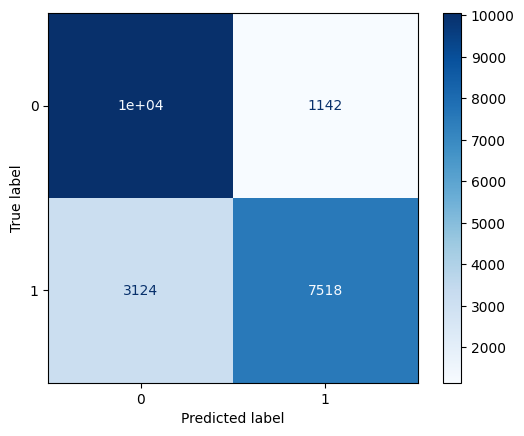

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(real_labels, pred_labels))
disp=ConfusionMatrixDisplay.from_predictions(real_labels, pred_labels, cmap=plt.cm.Blues)